In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq fastai # upgrade fastai on colab

In [ ]:
#| default_exp l2r.data.load

In [ ]:
#| export
from PIL import Image
from fastai.torch_imports import *
from fastai.data.load import DataLoader
from xcube.imports import *
from xcube.torch_imports import *
from xcube.fastai_imports import *

In [ ]:
#| hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# L2R DataLoader

> DataLoader for L2R applications. 

This module contains all the classes and supporting fuctions to build a `L2RDataLoader`.

The method `quantized_score` **[simulates Pandas `groupby` using `Numpy/PyTorch`](https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/38015063#38015063):** (Why? `Pandas` are cute but speed thrills! More importantly: "Memory")

In [ ]:
#| export
class PreLoadTrans():
    def __init__(self, df, qnts=None, device=None): store_attr()

    @property
    def num_lbs(self): return self._num_lbs
    @num_lbs.setter
    def num_lbs(self, l): self._num_lbs = l
    
    @property
    def num_toks(self): return self._num_toks
    @num_toks.setter
    def num_toks(self, t): self._num_toks = t
    
    def quantized_score(self, qnts=None):
        "computes quantize the rank column of `self.df['rank']` based on `qnts`"

        if qnts is None:
            qnts = torch.concat([torch.Tensor([0]), torch.logspace(torch.log10(torch.tensor(1e-4)), torch.log10(torch.tensor(1)), 100)])
        qnts = to_device(qnts, self.device)
        # import pdb; pdb.set_trace()
        # from IPython import embed; embed()
        data = qnts.new_tensor(self.df.to_numpy())
        test_eq(data.shape, (len(self.df), 3)) # dim1 is a 3 tuple (token, label, rank)
        # sort by the labels
        data = data[data[:, 1].argsort()]
        # indices of the unique labels
        # import pdb; pdb.set_trace()
            # splt_idxs = np.concatenate([torch.as_tensor(np.unique(data[:, 1].cpu().numpy(), return_index=True)[1], self.device=default_self.device(), dtype=torch.int).cpu().numpy(), array([len(data)])])
            # splt_idxs = list(splt_idxs[1:] - splt_idxs[:-1])
        splt_idxs = np.unique(data[:, 1].cpu().numpy(), return_index=True)[1][1:]
        # split by the unique labels
        data = np.split(data.cpu().numpy(), splt_idxs)
        # stacking the 0th dim with label specific data
        data = np.stack(data)
        # data = torch.as_tensor(data, dtype=qnts.dtype)
        data = qnts.new_tensor(data)
        # test_eq(data.shape, (8922, 57352, 3))
        # computing the bins based on qnts
        bins = torch.quantile(data[:, :, -1], qnts, dim=1)
        # test_eq(bins.shape, (101, 8922))
        # placing relevance scores right next to ranks
        relv_scores = bins.shape[0] - torch.searchsorted(bins.T, data[:, :, -1], right=False) # shape (8922, 57352)
        data = torch.cat((data, relv_scores.unsqueeze(-1)), dim=-1)
        # data[:, :, -1] = relv_scores
        self.num_lbs, self.num_toks = data.shape[:2]
        self.scored_toks = data
        return self.scored_toks # dim 0: labels, dim 1: 3 tuple (token, label, rank, score)

    def train_val_split(self):
        test_eq(self.scored_toks.shape, (self.num_lbs, self.num_toks, 4))
        qnts = (1 - torch.concat([tensor([0.]), torch.logspace(torch.log10(tensor(1e-4)), torch.log10(tensor(1.)), 10)])).flip(dims=(0,))
        test_eq(qnts.shape, [11])
        bins = torch.quantile(self.scored_toks[:, :, -1], qnts, dim=1)
        test_eq(bins.shape, (11, self.num_lbs))
        binned_toks = torch.searchsorted(bins.T, self.scored_toks[:, :, -1])
        test_eq(binned_toks.shape, (self.num_lbs, self.num_toks))
        # import pdb; pdb.set_trace()
        bin_nums = binned_toks[0].unique() # all the labels have same binning because we are quantizing the scores
        right_bds = bins[:, 0][bin_nums]
        left_bds = torch.concat([tensor([-torch.inf]), bins[:, 0][bin_nums[1:]-1]])
        bin_bds = torch.concat((left_bds[:,None], right_bds[:, None]), dim=1)
        bin_size = torch.bincount(binned_toks[0])
        probs = binned_toks.new_ones(binned_toks.shape).div(3.*bin_size[binned_toks])
        # probs[bin_size[binned_toks] > 4] = 2.*probs[bin_size[binned_toks] > 4] 
        # probs[bin_size[binned_toks] <= 4] = 0.001*probs[bin_size[binned_toks] <= 4] 
        probs[binned_toks < bin_nums[-2]] = 2.*probs[binned_toks < bin_nums[-2]] 
        # probs[bin_size[binned_toks] <= 4] = 0.001*probs[bin_size[binned_toks] <= 4] 
        is_valid = torch.bernoulli(probs)
        self.binned_toks, self.probs, self.is_valid, self.bin_size, self.bin_bds = binned_toks, probs, is_valid, bin_size, bin_bds
        return self.scored_toks, self.binned_toks, self.probs, self.is_valid, self.bin_size, self.bin_bds

In [ ]:
#| export
@patch
def pad_split(self:PreLoadTrans):
    "pads the validation set for each label to the nearest multiple of 16"
    val_sizes = self.is_valid.sum(dim = -1)
    sl = 16 * torch.floor(val_sizes.max()/16) + 16
    self.val_sl = sl.int().item()
    deficit = (sl - val_sizes).int()
    top3bins = self.binned_toks[0].unique().sort(descending=True)[0][:3]
    for i,d in enumerate(deficit):
        val_idxs = torch.where(self.is_valid[i]==True)[0]
        trn_idxs = torch.where(self.is_valid[i]==False)[0]
        top3idxs = torch.where(torch.isin(self.binned_toks[i], top3bins))[0].sort()[0]
        trn_idxs = torch.as_tensor(np.setdiff1d(trn_idxs.cpu().numpy(), top3idxs.cpu().numpy()))
        more_val_idxs = trn_idxs[torch.randperm(len(trn_idxs))[:d].long()]
        self.is_valid[i][more_val_idxs] = 1
    return self.val_sl

In [ ]:
#| export
@patch
def count_topbins(self:PreLoadTrans):
    "counts the number of top 2 bins in the val set for each label"
    top_lens = self.binned_toks.new_zeros(self.binned_toks.shape[0]) # for every label contains the number of top 2 bins (top bins are the ones which have most relevant tokens for that label) 
    top_bins = self.binned_toks[0].unique()[-2:]
    for i, binned in enumerate(self.binned_toks):
        topbin_idxs = torch.nonzero(torch.isin(binned, top_bins)).view(-1)
        val_idxs = torch.where(self.is_valid[i] == 1)[0]
        top = val_idxs[torch.where(torch.isin(val_idxs, topbin_idxs))[0]]
        top_lens[i] = top.shape[0]
    return top_lens

In [ ]:
#| export
@patch
def datasets(self:PreLoadTrans):
    "prepare the train/val dataset from `self.scored_toks`"
    self.val_dset = self.scored_toks[self.is_valid.bool()].view(self.scored_toks.shape[0], self.val_sl, -1)
    # trn = self.scored_toks[~self.is_valid.bool()].view(self.scored_toks.shape[0], self.scored_toks.shape[1]-self.val_sl, -1) # Use this if you want to remove validation tokens
    self.trn_dset = self.scored_toks
    return self.trn_dset, self.val_dset

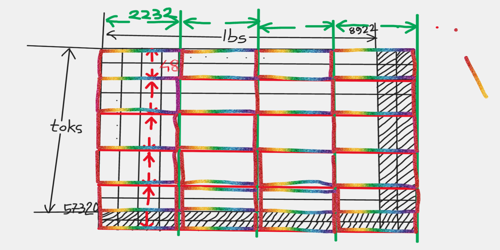

In [ ]:
img = Image.open(Path.cwd()/'pics'/'LRdataloader.png').resize((500,250))
img

In [ ]:
#| export
class L2RDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        self.sl, self.lbs_chunks = kwargs.pop('sl', None), kwargs.pop('lbs_chunks', None)
        if self.sl is None: self.sl = 64
        if self.lbs_chunks is None: self.lbs_chunks = 4
        super().__init__(*args, **kwargs)
        
    def randomize(self):
        seed = np.random.default_rng().integers(0, 2**32-1, 1).item()
        self.rng = np.random.default_rng(seed)
    
    def shuffle_fn(self, idxs): return self.rng.permutation(idxs)

    def get_idxs(self):
        if self.n is not None: idxs = range(self.n)
        if self.shuffle: idxs = (idx for idx in self.shuffle_fn(idxs))
        return idxs
    
    def create_batch(self, start_idx):
        return self.dset[start_idx: min(start_idx+self.bs, self.dset.shape[0])]
        
    def __len__(self):
        return int(np.ceil((np.ceil(self.dataset.shape[1]/self.sl) * self.lbs_chunks)/self.bs))
    
    def before_iter(self):
        # shuffling
        # randperm = torch.randint(low=0, high=self.dataset.shape[1], size=(self.dataset.shape[1],))
        randperm_idxs = torch.randperm(self.dataset.shape[1])
        self.dataset = self.dataset[:, randperm_idxs]
        size_of_dim0 = torch.ceil(self.dataset.new_empty(1).fill_(self.dataset.shape[0]/self.lbs_chunks)).item()
        pad_len_dim0 = int(self.lbs_chunks * np.floor(self.dataset.shape[0]/self.lbs_chunks) + self.lbs_chunks - self.dataset.shape[0])
        self.dataset_pad = F.pad(self.dataset, (0,0,0,0,0,pad_len_dim0), value=-1)

        trn_sqs = list(torch.split(self.dataset_pad, split_size_or_sections=self.sl, dim=1))
        test_eq(len(trn_sqs), np.ceil(self.dataset_pad.shape[1]/self.sl))
        test_eq(trn_sqs[-1].shape, (self.dataset_pad.shape[0], self.dataset_pad.shape[1]%self.sl,4))
        deficit = self.sl - trn_sqs[-1].shape[1]
        if deficit: 
            test_eq(trn_sqs[-1].shape, (self.dataset_pad.shape[0], self.dataset_pad.shape[1]%self.sl,4));
            trn_sqs[-1] = trn_sqs[-1].repeat_interleave(self.sl//trn_sqs[-1].shape[1], dim=1)
        test_eq(trn_sqs[-1].shape, (self.dataset_pad.shape[0], self.sl,4));
        
        trn_sqs = map(partial(torch.chunk, chunks=self.lbs_chunks), trn_sqs)
        trn_sqs = itertools.chain.from_iterable(trn_sqs)
        self.dset = trn_sqs
    
    def create_batches(self, samps):
        yield from (torch.stack(btch) for btch in self.chunkify(self.dset))
        

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()